Классическая задача теории прогноза состоит в том, чтобы на основе известной части временного ряда $\left \{ x_1, x_2, x_3, x_4, \dots, x_N \right \}$ генерировать его следующие члены $x_{N+1}, x_{N+2}$  и т.д.

Пусть ряд генерируется простой системой с хаотическим аттрактором ( например, логистическим отображением при $\lambda=4 : x_{n+1} = 4x_n(1-x_n)$ или аттрактором Хенона
\begin{equation*}
x_{n+1} = y_n + 1 -ax_n, y_{n+1}=bx_n
\end{equation*}

(например, при a=1.4, b=0.3).

Используя трехслойную нейронную сеть (подобрав разумное число нейронов в каждом слое), алгоритмом обратного распространения ошибки, построить предсказывающую систему, которой на вход подается $x_{p_1}, \dots, x_{p+k}$, а на выходе должно быть $x_{p+k+1}$. Сравнить горизонт прогноза для исходной системы и для «предсказывающей машины».

Советы решающему.

Последнее разумно сделать, сравнив ляпуновские показатели для исходной системы с динамическим хаосом и нейросетевого предиктора.

In [1]:
def logistic_map(par_lambda, x):
    return par_lambda * x * (1 - x)

def verhulst_map(par_lambda, x):
    return 1 - par_lambda * x * x

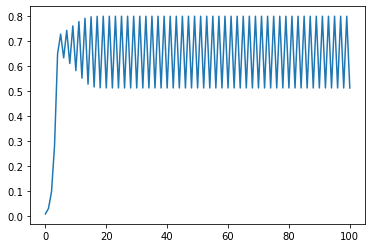

In [126]:
import matplotlib.pyplot as plt
import numpy as np

par_lambda = 3.2
x = 0.01
bar = [x]
for i in range(100):
    x = logistic_map(par_lambda, x)
    bar.append(x)
plt.plot(np.arange(101), np.array(bar))
plt.show()

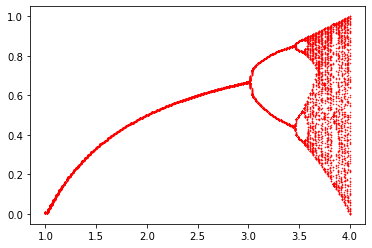

In [127]:
lambda_array = []
x_array = []
x_start = x_cur = 0.01

for par_lambda in np.linspace(1, 4, 200):
    x_cur = x_start
    for _ in range(100):
        x_cur = logistic_map(par_lambda, x_cur)
        
        lambda_array.append(par_lambda)
        x_array.append(x_cur)
    x_start = x_cur

plt.plot(lambda_array, x_array, "r.", ms=1)
plt.savefig("img/logistic_map_tree.png")
plt.show()

Test: [0.7655391721852274]
Emily = [0.9520928345716464]
Frank = [0.03678769870182042]


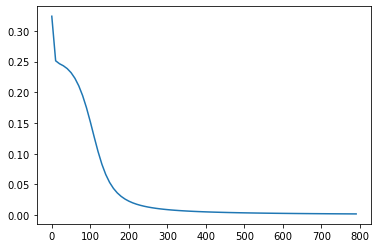

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() 

def sigmoid(x, deriv = False):
    return 1 / (1 + np.exp(-x))

def deriv(x):
    return x * (1 - x)

class Neuron:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
    def feedforward(self, inputs):
        total = np.dot(self.weights, inputs) + self.bias
        return sigmoid(total)
    
    def inspect(self):
        print(f"Weights = {self.weights}, bias = {self.bias}, shift = {self.shift}")

class NeuronLayer:
    def __init__(self, amnt_neurons, input_size):
        weights = np.ones(input_size) * 0.5
        self.list_neurons = [Neuron(weights, 0.5) for _ in range(amnt_neurons)]
        
    def feedforward(self, inputs):
        self.inputs = inputs
        self.outputs = [cur_neuron.feedforward(inputs) for cur_neuron in self.list_neurons]
    
    def get_output(self):
        return self.outputs
    
    def inspect(self):
        print(f"Amount of neurons = {len(self.list_neurons)}, inputs = {self.inputs}, outputs = {self.outputs}\n")
        
class NeuronNetwork:
    def __init__(self, size_first_layer, info):
        self.list_hidden_layers = [NeuronLayer(value, size_first_layer) if key == 0 else NeuronLayer(value, info[key - 1]) for key, value in info.items()]
        self.final_layer = NeuronLayer(1, list(info.values())[-1])
        
    def feedforward(self, inputs):
        cur_inputs = inputs
        for i in self.list_hidden_layers:
            i.feedforward(cur_inputs)
            cur_inputs = i.get_output()
        
        self.final_layer.feedforward(cur_inputs)
        self.prediction = self.final_layer.get_output()
        return self.prediction
    
    def get_prediction(self):
        return self.prediction
    
    def inspect(self):
        print(f"Amount of hidden layers = {len(self.list_hidden_layers)}")
    
    def back_propogation(self, output, lr):
        weight = 0
        y_true, y_pred = output, self.prediction[0]
        
        self.final_layer.list_neurons[0].shift = -2 * (y_true - y_pred) * deriv(y_pred)
        
        all_layers = self.list_hidden_layers + [self.final_layer]
         
        for num_layer, layer in enumerate(all_layers[::-1][1:], start = 1):
            for num_neuron, neuron in enumerate(layer.list_neurons): #НОВЫЙ СЛОЙ
                for layer_2 in all_layers[::-1][:num_layer]: #ИДЁМ ПО СТАРЫМ СЛОЯМ
                    for neuron_2 in layer_2.list_neurons:
                        weight += neuron_2.shift * neuron_2.weights[num_neuron]           
                neuron.shift = weight * deriv(layer.outputs[num_neuron])
                weight = 0
        
        for layer in self.list_hidden_layers: 
            for num, neuron in enumerate(layer.list_neurons):
                neuron.weights -= lr * neuron.shift * np.array(layer.inputs)
                neuron.bias -= lr * neuron.shift
        
        self.final_layer.list_neurons[0].weights -= lr * self.final_layer.list_neurons[0].shift * np.array(self.final_layer.inputs)
        self.final_layer.list_neurons[0].bias -= lr * self.final_layer.list_neurons[0].shift
        
    def train(self, inputs, outputs, amnt_epochs):
        self.epochs = []
        self.mse_errors = []
        lr = 0.2
        
        for epoch in range(amnt_epochs):
            for cur_x, cur_y in zip(inputs, outputs):
                self.feedforward(cur_x)
                self.back_propogation(cur_y, lr)
                
            if epoch % 10 == 0:
                self.epochs.append(epoch)
                y_preds = np.apply_along_axis(self.feedforward, 1, inputs)
                self.mse_errors.append(mse_loss(np.ravel(y_preds), outputs))


amnt_hidden_layers = 2
amnt_hidden_neurons = [2, 2]
size_first_layer = 2
info_hidden_layers = dict(zip(range(amnt_hidden_layers), amnt_hidden_neurons))

data = np.array([[-2, -1], [25, 6], [17, 4], [-15, -6]])
all_y_trues = np.array([1, 0, 0, 1])

network = NeuronNetwork(size_first_layer, info_hidden_layers)
print(f"Test: {network.feedforward(data[0])}")
network.train(data, all_y_trues, amnt_epochs = 800)

plt.plot(network.epochs, network.mse_errors)
plt.show

emily = np.array([-7, -3]) # 128 pounds, 63 inches
frank = np.array([20, 2])  # 155 pounds, 68 inches
print(f"Emily = {network.feedforward(emily)}")
print(f"Frank = {network.feedforward(frank)}")

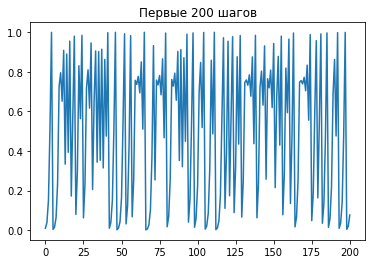

First test: prediction = [0.9802739789800502], true_result = 0.9863789719770243
Second test: prediction = [0.4728899453765493], true_result = 0.12062037027984196
Real lyapunov exponent = 0.7006665543186741
Calculated lyapunov exponent = -1.4635547017151531
5 185
180


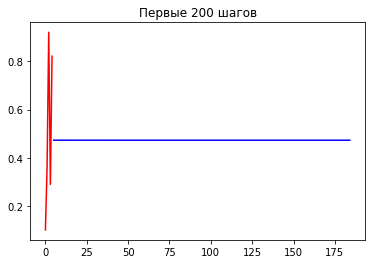

<function matplotlib.pyplot.show(*args, **kw)>

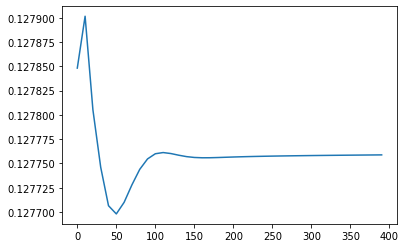

In [117]:
def get_lyapunov_exponent(x):
    r = 4
    result = []
    for cur_element in x:
        result.append(np.log(abs(r - 2*r*x)))
    return np.mean(result)

def get_logistic_map_bar(x_start, par_lambda, amnt_iterations):
    par_lambda = 4
    x = x_start
    bar = [x_start]
    for i in range(amnt_iterations):
        x = logistic_map(par_lambda, x)
        bar.append(x)
    return np.array(bar)

bar_plot = get_logistic_map_bar(0.01, 4, 200)
bar_test = get_logistic_map_bar(0.1, 4, 8000)

plt.plot(np.arange(200 + 1), bar_plot)
plt.title("Первые 200 шагов")
plt.show()


amnt_hidden_layers = 2
amnt_hidden_neurons = [7, 7]
size_first_layer = 5
info_hidden_layers = dict(zip(range(amnt_hidden_layers), amnt_hidden_neurons))

net = NeuronNetwork(size_first_layer, info_hidden_layers)

train_data = []
train_results = []
test_data = []
test_results = []
amnt_train_tests = 200
amnt_iters = 180

for i in range(amnt_train_tests):
    train_data.append(bar_test[i * size_first_layer:i * size_first_layer + size_first_layer])
    train_results.append(bar_test[i * 20 + size_first_layer])
    
for i in range(10):
    test_data.append(bar_test[200 + i:200 + i + size_first_layer])
    test_results.append(bar_test[200 + i + size_first_layer])
    
train_data = np.array(train_data)
train_results = np.array(train_results)
test_data = np.array(test_data)
test_results = np.array(test_results)

print(f"First test: prediction = {net.feedforward(train_data[1])}, true_result = {train_results[1]}")

net.train(train_data, train_results, amnt_epochs = 400)
print(f"Second test: prediction = {net.feedforward(test_data[1])}, true_result = {test_results[1]}")
print(f"Real lyapunov exponent = {get_lyapunov_exponent(bar_plot)}")

init_data = np.ravel(train_data[0])
for i in range(amnt_iters):
    init_data = np.append(init_data, net.feedforward(init_data[i:i + size_first_layer]))

print(f"Calculated lyapunov exponent = {get_lyapunov_exponent(init_data)}")

plt.plot(np.arange(init_data[:size_first_layer].size), init_data[:size_first_layer],"r")
plt.plot(np.arange(size_first_layer, init_data.size), init_data[size_first_layer:],"b")
plt.title("Первые 200 шагов")
plt.show()

plt.plot(net.epochs, net.mse_errors)
plt.show